# 웨딩 체형 관리가 감정에 미치는 영향 분석

## 온라인 커뮤니티 데이터를 활용한 준실험 분석

웨딩 준비 과정은 기대와 설렘을 안겨주지만, 동시에 체형 관리에 대한 사회적 압박을 동반하기도 합니다.
이러한 압박은 개인의 스트레스 수준에 영향을 미칠 수 있습니다.

본 연구는 실제 온라인 커뮤니티에 게시된 글들을 분석하여, 웨딩 체형 관리가 스트레스에 미치는 상반된 두 가지 효과를 살펴보고자 합니다.

- **압박 효과**: 체형 관리를 위한 자기 통제와 사회적 기대가 스트레스를 증가시킨다.

- **기대 효과**: 결혼을 앞둔 기대감이 긍정적인 정서를 이끌어낼 수 있다.


## 분석 절차

1. 데이터 구성 및 변수 정리

2. 토픽 모델링 및 처치 배정

3. 스트레스 및 긍정 감정 점수 추정  

4. 인과 효과 추정 (Inverse Probability Weighting)  

5. Robustness Check (민감도 분석 및 커뮤니티별 분석)  

6. 결론 및 시사점

In [49]:
!pip install bertopic > /dev/null
!pip install transformers > /dev/null

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

import json
from textwrap import wrap
import numpy as np
import pandas as pd
import duckdb

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression

from joblib import Parallel, delayed

# BERTopic & Hugging Face
from bertopic import BERTopic
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    logging as hf_logging
)

hf_logging.set_verbosity_error()

pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 20)


## 분석 대상 커뮤니티 및 데이터 구성

### 분석 대상 커뮤니티

웨딩 관련 체형 관리 논의를 분석하기 위해 다음 두 커뮤니티를 선정합니다.

- [**The Knot - Getting in Shape**](https://forums.theknot.com/categories/wedding-boards_getting-shape): 웨딩 준비 과정에서의 체형 관리 논의가 활발히 이루어지는 웨딩 특화 포럼

- [**Reddit - r/xxfitness**](https://www.reddit.com/r/xxfitness/): 피트니스, 다이어트 등 일반적인 체형 관리를 주제로 한 여성 중심 커뮤니티


### 데이터 구성 및 주요 변수

- **`post_id`**: 게시글 고유 ID  
- **`main_content`**: 원본 게시글 텍스트
- **`community`**: 커뮤니티 출처(The Knot / xxfitness)  
- **`clean_content`**: 전처리된 텍스트 (HTML, URL, 특수문자 제거)
  - 감성 분석 및 문장 임베딩 생성에 사용됩니다.
- **`embedding`**: SBERT(`all-mpnet-base-v2`) 기반 문장 임베딩  
  - BERTopic 기반 토픽 모델링에 활용됩니다.
- **`year/month`**: 게시글 작성 시점
- **`title`, `author`, `replies`**: 기타 메타데이터 (제목, 작성자 ID, 댓글 수 등)



In [2]:
df = pd.read_parquet("community_data_preprocessed_with_embedding.parquet")

print("전체 데이터 개수:", len(df))
display(df.head())

전체 데이터 개수: 3198


,post_id,title,url,author,creation_date,replies,views,main_content,comments,community,query,year,month,views_numeric,tokens,token_count,clean_content,embedding
0,1041017,MyFitnessPal,https://forums.theknot.com...,ohmrs2014,2014-10-01 11:33:20+00:00,50,1.7K,Hey everyone. Since it app...,[{'comment_id': 'Comment_7...,theknot,None,2014,10,1700.0,"[hey, everyone, appear, pe...",59,Hey everyone. Since it app...,"[-0.0060079666, 0.02585061..."
1,1064173,Accountability Thread,https://forums.theknot.com...,ohmrs2014,2015-09-30 21:01:09+00:00,14,494,Here is the accountability...,[{'comment_id': 'Comment_7...,theknot,None,2015,9,494.0,"[accountability, thread, u...",12,Here is the accountability...,"[0.0013044394, 0.055405546..."
2,984005,Share a Recipe Friday?,https://forums.theknot.com...,Lobsters25,2013-06-28 13:01:44+00:00,32,1.3K,"So I'm a wee bit bored, ev...",[{'comment_id': 'Comment_6...,theknot,None,2013,6,1300.0,"[wee, bit, bore, thing, ge...",120,"So I'm a wee bit bored, ev...","[-0.024539845, 0.03900958,..."
3,1048438,Just a Friendly Reminder,https://forums.theknot.com...,ohmrs2014,2015-01-07 01:01:42+00:00,0,425,Hey fellow Knotties. I lov...,[],theknot,None,2015,1,425.0,"[hey, fellow, knotties, lo...",66,Hey fellow Knotties. I lov...,"[0.08700552, 0.029714217, ..."
4,1043985,FAQ for Getting in Shape B...,https://forums.theknot.com...,KnotRiley,2014-11-05 16:33:33+00:00,0,527,Hi! Welcome to the GIS bo...,[],theknot,None,2014,11,527.0,"[hi, gi, board, great, gro...",190,Hi! Welcome to the GIS boa...,"[0.0643553, 0.05652456, -0..."


## 토픽 모델링 및 처치 배정

체형 관리와 관련된 게시글을 분석 대상으로 설정하고, 이 중 웨딩 관련 논의가 포함된 경우를 처치군으로 정의합니다.

이를 위해 BERTopic 기반의 토픽 모델링을 활용해 각 게시글의 주제를 추정하고, 다음과 같은 절차를 통해 처치를 배정합니다:

1. **토픽 모델링**  
   - 전처리된 텍스트(`clean_content`)와 SBERT 임베딩(`embedding`)을 활용해 BERTopic으로 게시글을 유사한 주제별로 클러스터링합니다.
   - 각 게시글에 대해 토픽별 확률 분포를 계산합니다.

2. **토픽 분류 및 키워드 매칭**  
   - 사전에 정의한 웨딩 및 체형 관련 키워드를 바탕으로 각 토픽을 분류하고, 이 분류 결과를 통해 관심 토픽을 선정합니다.

3. **토픽 확률 계산 및 임계값 설정**  
   - 각 게시글이 웨딩 또는 체형 관련 토픽과 얼마나 밀접한지를 나타내는 확률값을 추출합니다.
   - 해당 확률 분포의 상위 70% 분위수를 임계값으로 설정하여, 분석에 적합한 게시글을 선별합니다.

4. **처치군/대조군 배정**  
   - **처치군(Treatment)**: 웨딩 및 체형 관련 토픽 확률이 모두 임계값 이상이며, 두 가지 키워드를 포함한 게시글
   - **대조군(Control)**: 체형 관련 토픽 확률만 임계값 이상이며, 체형 키워드만 포함한 게시글
   - **제외군(Exclude)**: 위 조건을 만족하지 않는 게시글

### 토픽 모델링

체형 관리와 웨딩 관련 논의를 정량적으로 구분하기 위해, BERTopic을 활용하여 게시글의 주제를 클러스터링합니다.

- **입력**: `clean_content`와 `embedding`  
- **출력**: 각 게시글에 대한 토픽 ID와 토픽 확률 분포 (`topic_probabilities`)

> BERTopic은 SBERT 임베딩을 기반으로 유사한 의미를 가진 문서들을 클러스터링하여, 주제 단위의 토픽으로 그룹화하는 모델입니다.

In [3]:
data_path = "df_with_topics.parquet"
model_path = "wedding_weight_bertopic.pkl"

df = pd.read_parquet(data_path)

if os.path.exists(model_path) and "topic_probabilities" in df.columns:
    topic_model = BERTopic.load(model_path)
else:
    # 토픽 모델 학습
    contents = df['clean_content'].fillna('').astype(str).tolist()
    embeddings = np.array(df['embedding'].tolist())

    topic_model = BERTopic(calculate_probabilities=True, min_topic_size=10)
    topics, probs = topic_model.fit_transform(contents, embeddings)

    # 결과 저장
    df['topic'] = topics
    df['topic_probabilities'] = probs.tolist()

    topic_model.save(model_path)
    df.to_parquet(data_path)

In [4]:
topic_info = topic_model.get_topic_info()
display(topic_info)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1047,-1_and_to_the_my,"[and, to, the, my, of, for...",[Disclaimer: this is not m...
1,0,283,0_dress_wedding_my_to,"[dress, wedding, my, to, a...","[Omg guys, call me silly, ..."
2,1,201,1_the_and_that_to,"[the, and, that, to, of, w...",[Is anyone else on the rec...
3,2,159,2_my_to_and_the,"[my, to, and, the, of, was...",[Disclaimer this is super ...
4,3,122,3_today_the_weekend_morning,"[today, the, weekend, morn...",[Good morning everyone! I ...
...,...,...,...,...,...
44,43,12,43_skin_face_my_and,"[skin, face, my, and, it, ...",[As someone with naturally...
45,44,12,44_buddy_survey_matching_b...,"[buddy, survey, matching, ...",[I've seen a lot of posts ...
46,45,12,45_chest_bra_breast_breasts,"[chest, bra, breast, breas...",[The title pretty much exp...
47,46,11,46_race_running_half_miles,"[race, running, half, mile...","[Hello, runners! In a norm..."


### 토픽 분류

각 토픽의 대표 단어를 기준으로, 사전에 정의한 키워드 집합과의 일치 여부를 확인하여 웨딩 관련 토픽과 체형 관련 토픽으로 분류합니다.

In [5]:
# 웨딩 관련 키워드
wedding_keywords = {
    'wedding', 'bride', 'dress', 'marriage', 'fiance', 'groom', 'ceremony', 'engagement'
}

# 체형 관련 키워드
body_keywords = {
    'weight', 'diet', 'calorie', 'fat', 'lose', 'gain', 'body', 'shape',
    'waist', 'hip', 'scale', 'pounds', 'cuttingweight'
}

In [6]:
def classify_topic(words_list, keyword_set):
    return any(any(k in word.lower() for k in keyword_set) for word in words_list)

In [7]:
wedding_topic_ids, body_topic_ids = [], []
topic_words = {}

for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    if topic_id == -1:
       continue

    words_list = row['Representation']
    topic_words[topic_id] = words_list

    if classify_topic(words_list, wedding_keywords):
        wedding_topic_ids.append(topic_id)
    if classify_topic(words_list, body_keywords):
        body_topic_ids.append(topic_id)

# 중복 제거 및 정렬
wedding_topic_ids = sorted(set(wedding_topic_ids))
body_topic_ids = sorted(set(body_topic_ids))

In [8]:
print("\n------ [웨딩 토픽 목록] ------\n")
for topic_id in wedding_topic_ids:
    print(f"topic_id = {topic_id:>2}, words = {topic_words[topic_id]}")

print("\n------ [체형 토픽 목록] ------\n")
for topic_id in body_topic_ids:
    if topic_id in wedding_topic_ids:
        continue
    print(f"topic_id = {topic_id:>2}, words = {topic_words[topic_id]}")


------ [웨딩 토픽 목록] ------

topic_id =  0, words = ['dress', 'wedding', 'my', 'to', 'and', 'the', 'in', 'weight', 'have', 'im']
topic_id =  5, words = ['wedding', 'to', 'you', 'we', 'challenge', 'and', 'group', 'in', 'me', 'on']
topic_id = 21, words = ['cake', 'our', 'us', 'pictures', 'was', 'we', 'it', 'the', 'wedding', 'of']

------ [체형 토픽 목록] ------

topic_id =  2, words = ['my', 'to', 'and', 'the', 'of', 'was', 'in', 'for', 'on', 'weight']
topic_id =  4, words = ['calories', 'eat', 'eating', 'and', 'to', 'of', 'the', 'my', 'food', 'diet']
topic_id =  6, words = ['nbsp', 'chicken', 'with', 'and', 'you', 'of', 'eat', 'for', 'mealdescriptioncalories', 'to']
topic_id =  8, words = ['101', 'here', 'gain', 'loss', 'absa', 'cuttingweight', 'bulkingweight', 'rbulkorcut', 'rgainit', 'bulks']
topic_id = 11, words = ['my', 'shape', 'butt', 'body', 'hips', 'upper', 'legs', 'thighs', 'and', 'have']
topic_id = 17, words = ['weight', 'and', 'lose', 'my', 'been', 'im', 'to', 'but', 'ive', 'the']
to

### 토픽 확률 합산 및 임계값 설정

각 게시글이 웨딩 또는 체형 관련 주제에 얼마나 밀접하게 연관되어 있는지를 평가하기 위해, 다음 확률값을 계산합니다:

- `wedding_prob`: 웨딩 관련 토픽들의 확률 합  
- `body_prob`: 체형 관련 토픽들의 확률 합

각 확률 분포의 상위 70% 분위수를 임계값으로 설정하여, 주제와의 관련성이 높은 게시글을 선별합니다.


In [9]:
# 그룹별(웨딩/체형) 토픽 확률 합산
def get_topic_group_prob(prob_row, topic_ids):
    return sum([prob_row[topic_id] for topic_id in topic_ids if topic_id < len(prob_row)])

In [10]:
# 각 게시글별 웨딩 및 체형 관련 토픽 확률 합산
df['wedding_prob'] = df['topic_probabilities'].apply(lambda x: get_topic_group_prob(x, wedding_topic_ids))
df['body_prob'] = df['topic_probabilities'].apply(lambda x: get_topic_group_prob(x, body_topic_ids))

In [11]:
# 각 토픽 확률의 상위 70% 분위수를 임계값으로 설정
body_threshold = df['body_prob'].quantile(0.70)
wedding_threshold = df['wedding_prob'].quantile(0.70)

print("체형 관련 임계값 (70%):", body_threshold)
print("웨딩 관련 임계값 (70%):", wedding_threshold)

체형 관련 임계값 (70%): 0.23788591137673668
웨딩 관련 임계값 (70%): 0.04136821626518921


### 처치군/대조군 배정

앞서 계산한 토픽 확률과 키워드 포함 여부를 기준으로, 각 게시글을 다음과 같이 세 개의 그룹으로 분류합니다:

- **처치군(Treatment)**:  
  - `body_prob`가 임계값 이상이며, 체형 관련 키워드를 포함하고
  - `wedding_prob`도 임계값 이상이며, 웨딩 관련 키워드를 포함한 게시글

- **대조군(Control)**:  
  - `body_prob`가 임계값 이상이며, 체형 관련 키워드는 포함하지만
  - `wedding_prob`이 임계값 미만이거나 웨딩 관련 키워드가 포함되지 않은 게시글

- **제외군(Exclude)**:  
  - 위 조건을 모두 충족하지 않는 나머지 게시글


In [12]:
# 웨딩 키워드 포함 여부 판단
df['has_wedding_keyword'] = df['clean_content'].apply(
  lambda x: any(keyword in x.lower() for keyword in wedding_keywords)
)

# 체형 키워드 포함 여부 판단
df['has_body_keyword'] = df['clean_content'].apply(
  lambda x: any(keyword in x.lower() for keyword in body_keywords)
)

In [13]:
def assign_group(row, wedding_thr, body_thr):
    if (row['body_prob'] >= body_thr) and row['has_body_keyword']:
        if (row['wedding_prob'] >= wedding_thr) and row['has_wedding_keyword']:
            return 'treatment'
        else:
            return 'control'
    else:
        return 'exclude'

df['group'] = df.apply(assign_group, axis=1, args=(wedding_threshold, body_threshold))

In [14]:
duckdb.query("""
    SELECT
        community,
        SUM(CASE WHEN "group" = 'treatment' THEN 1 ELSE 0 END) AS treatment_count,
        SUM(CASE WHEN "group" = 'control' THEN 1 ELSE 0 END) AS control_count,
        SUM(CASE WHEN "group" = 'exclude' THEN 1 ELSE 0 END) AS exclude_count
    FROM df
    GROUP BY community

    UNION ALL

    SELECT
        'Total' AS community,
        SUM(CASE WHEN "group" = 'treatment' THEN 1 ELSE 0 END) AS treatment_count,
        SUM(CASE WHEN "group" = 'control' THEN 1 ELSE 0 END) AS control_count,
        SUM(CASE WHEN "group" = 'exclude' THEN 1 ELSE 0 END) AS exclude_count
    FROM df
""").df()

,community,treatment_count,control_count,exclude_count
0,theknot,236.0,173.0,991.0
1,xxfitness,41.0,403.0,1354.0
2,Total,277.0,576.0,2345.0


In [15]:
pd.set_option('display.max_colwidth', None)

duckdb.query("""
    WITH ranked AS (
        SELECT
            post_id,
            "group",
            community,
            main_content,
            body_prob,
            wedding_prob,
            ROW_NUMBER() OVER (PARTITION BY "group" ORDER BY RANDOM()) as rn
        FROM df
    )
    SELECT
        post_id,
        "group",
        community,
        main_content,
        body_prob,
        wedding_prob
    FROM ranked
    WHERE rn = 1
""").df()

,post_id,group,community,main_content,body_prob,wedding_prob
0,py04yc,control,xxfitness,"(Not sure if this is the right place to post this question; please lmk if it's best fitted for another subreddit.) I'm a younger 5'2 110lb AFAB woman — used to be quite underweight but I've been making some good progress in reaching a healthy range. I'm a dancer, so I have quite strong legs/feet and a rather strong core. However I'm very insecure about my arms: no matter how much weight I gain, they stay looking like twigs. I really want to have strong arms, not just because of how they look but also because feeling strong is a real confidence booster.\n\nI've tried working out my upper body many times, but I can barely do a single push-up, so it's difficult to keep up momentum when it feels so hopeless. I don't even know where to start. I've also never been to a real gym — money isn't an issue because the fitness center on campus is free — and the idea of walking in and not knowing how to work out is very intimidating. Help would be much appreciated, I've been struggling with this for a while but I don't want to let this insecurity hold power over me anymore.",0.296208,0.030349
1,1007601,exclude,theknot,I'm trying this to try to lose a few pounds before the big day! I have decided to cut out soda from my routine. I am going to try my best to loose at least five to ten pounds and going to work out regularly.,0.196227,0.096328
2,2qrkc5,treatment,xxfitness,"So since August of 2012 I've lost 85 lbs. I'm super excited about this and feel I've pretty much got to where I want to be weight wise, so I'm starting to tone. I started TRX this week and its been great. [Here are my pics!](http://imgur.com/a/dkH9N) The first is me 1 week post partum, the second is tonight. I went from 239 to 154, and I'm super happy about it.\n\nMy question is that right now I'm still holding weight around my waist. It's no where near as bad as it once was. but the last little bit of weight I lost came from my bust, and my waist remains virtually unchanged in the last 6 months. It's currently 35 inches whereas my bust is now 35.5 inches. I've had two giant babies who were 9lbs7.5oz and 11lbs2oz respectively so I don't expect a 6 pack or anything, but I'd like to lose a few more inches off my waist. I bought my wedding dress today and I had to size way up to accommodate this. Is this realistic, will it come with TRX/karate that I already do?",0.400580,0.289650


## 종속 변수

### 스트레스 수준 추정

게시글의 스트레스 수준은 사전학습된 텍스트 분류 모델 [`jnyx74/stress-prediction`](https://huggingface.co/jnyx74/stress-prediction)을 사용해 추정합니다.  
이 모델은 Reddit의 Dreaddit 데이터셋을 기반으로 훈련되었으며, 입력된 텍스트가 스트레스를 유발할 가능성을 확률값(0~1)으로 반환합니다 [(Turcan & McKeown, 2019)](https://arxiv.org/abs/1911.00133).

**적용 방식**:
  - 텍스트가 512자 이하인 경우, 전체 본문을 그대로 입력해 예측을 수행합니다.
  - 512자를 초과하는 경우, 본문을 500자 단위로 나눈 뒤 각 청크에 대해 예측을 수행하고, 해당 확률들의 평균을 `stress_score`로 사용합니다.

> 최종 산출된 `stress_score`는 0~1 범위의 연속형 변수로,  
> 웨딩을 앞둔 개인이 느끼는 **스트레스 수준**을 정량화하는 데 활용됩니다.


In [52]:
model_name = "jnyx74/stress-prediction"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

classifier = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

In [17]:
def get_score(text, classifier, label_set):
    if not isinstance(text, str) or not text.strip():
        return None

    try:
        if len(text) <= 512:
            result = classifier(text)[0]
            scores = [r["score"] for r in result if r["label"].lower() in label_set]
            return np.mean(scores) if scores else None
        else:
            chunks = wrap(text, 500)
            scores = []
            for chunk in chunks:
                result = classifier(chunk[:512])[0]
                scores.extend(
                    r["score"] for r in result if r["label"].lower() in label_set
                )
            return np.mean(scores) if scores else None
    except Exception as e:
        print(f"[Error in get_score] {e}")
        return None

In [18]:
df["stress_score"] = df["clean_content"].apply(
    lambda x: get_score(x, classifier, {"label_1"})
)

히스토그램을 보면, 처치군(Treatment)은 대조군(Control)에 비해 전반적으로 **스트레스 점수가 높은 방향으로 분포**하는 경향을 보입니다.  

특히 **0.8~1.0 구간**에서 처치군의 빈도가 더 높게 나타나며, 이는 **웨딩 관련 체형 관리 논의가 스트레스 수준 증가와 관련될 수 있음**을 시사합니다.


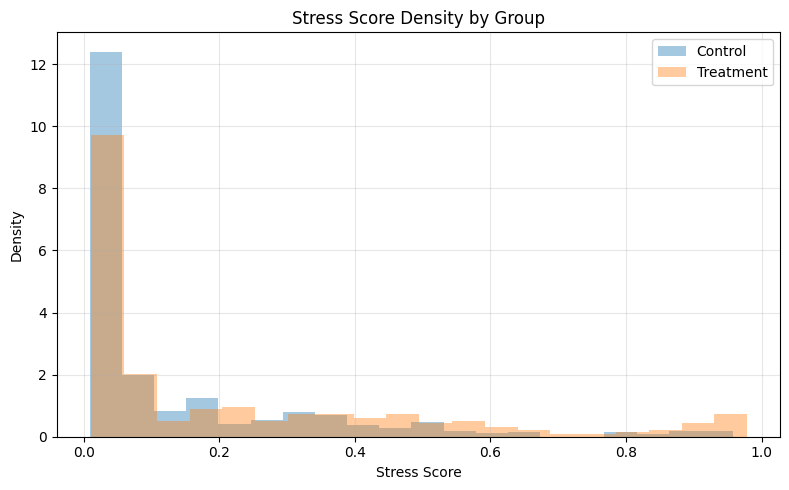

In [19]:
plt.figure(figsize=(8, 5))

plt.hist(
    df[df["group"] == 'control']["stress_score"].dropna(),
    bins=20,
    alpha=0.4,
    label="Control",
    density=True
)

plt.hist(
    df[df["group"] == 'treatment']["stress_score"].dropna(),
    bins=20,
    alpha=0.4,
    label="Treatment",
    density=True
)

plt.xlabel("Stress Score")
plt.ylabel("Density")
plt.title("Stress Score Density by Group")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
duckdb.query("""
    SELECT post_id, main_content, community, "group" AS grp, stress_score
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY "group" ORDER BY RANDOM()) AS rn
        FROM df
        WHERE "group" IN ('treatment', 'control')
    )
    WHERE rn = 1;
""").df()

,post_id,main_content,community,grp,stress_score
0,227943,"Hello all! I mostly just stick with posting on my local board or my wedding month board - so I am new here. For the last four months or so I have been doing CrossFit with a trainer in very small group classes after work about 3-5 weekly. It is pretty fairly priced for what it is ($120/month) and I have been mostly happy with it - until recently. For the last month and a half we have kinfd of strayed from CrossFit and started really focusing on weight training. Like Every Mon, Wed, and Fri. While I def like to hit the weights and I think they are an important part of working out, I really preferred the more cometitive and active CF workouts. Oh and guess what? Pricesare goign up $30 a month. Basically, I really should be putting a majority of this money towards my debt (student loans and CC) anyway so FI and I talked about a budget and that budget would give me enough for a typical gym membership. I am pretty set on ending this relationship, but I am just not sure how to bring it up. There are always at least 2 or 3 other people there at the same time as me - would it be appropriate for me to ""break up"" with him in front of others? Should I email/text/call? Wednesday would be my last day there, so I am hoping to have a game plan before then! TIA for any input you might have! Yes, I know I am beinga HUGE baby about this, I am just the kind of person that can't say no and I know he'll try to talk me into staying.",theknot,control,0.025079
1,1042720,"I hate to say this is happening right now in my life, but has anyone with a history of disordered eating found themselves triggered by the whole ""gotta fit into the wedding dress"" thing? I'm under enormous stress and pressure lately from other college and it's all sent me into a relapse spell. I feel terrified to do anything except be in panic, as illogical as that sounds. I am always feeling on the edge and emotional and can't concentrate well on getting anything good done. I really just want to be done with college and be married already, but I know this situation poses as a challenge towards me to either choose recovery or ED and that applies to me, my heart, and even my relationship with my future spouse. I feel like my mind is spiraling out of control and I wish I could simply make it all end right now. If anyone else is dealing with this, could we please support each other? Thank-you.",theknot,treatment,0.929081


### 긍정 점수 추정

게시글의 긍정 감정은 사전학습된 감성 분석 모델 [`cardiffnlp/twitter-roberta-base-sentiment`](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)를 사용해 추정합니다.  
이 모델은 약 5,800만 개의 트윗을 기반으로 학습된 RoBERTa 모델을 감성 분류용으로 미세 조정한 모델이며, 각 텍스트에 대해 `positive`, `neutral`, `negative` 확률을 반환합니다.

이 중 `positive` 확률값을 `positive_score`로 저장하여, 게시글의 긍정 감정 정도를 정량화합니다.

> `positive_score`는 0~1 범위의 연속형 변수로,  
> 웨딩 관련 논의가 긍정 정서에 미치는 영향을 평가하는 데 활용됩니다.


In [50]:
pos_model_name = "cardiffnlp/twitter-roberta-base-sentiment"

pos_tokenizer = AutoTokenizer.from_pretrained(pos_model_name)
pos_model = AutoModelForSequenceClassification.from_pretrained(pos_model_name)

pos_classifier = pipeline(
    "sentiment-analysis",
    model=pos_model,
    tokenizer=pos_tokenizer,
    return_all_scores=True
)

In [51]:
df["positive_score"] = df["clean_content"].apply(
    lambda x: get_score(x, pos_classifier, {"label_2", "positive"})
)

히스토그램을 보면, 처치군(Treatment)은 대조군(Control)에 비해 **긍정 점수의 양 극단에서 빈도가 높게 나타나는 분포**를 보입니다.  

특히 **0.0\~0.2 구간과 0.8\~1.0 구간**에서 처치군의 밀도가 상대적으로 높으며, 이는 **웨딩 관련 체형 관리 논의가 긍정 정서에 미치는 영향이 양면적으로 나타날 수 있음**을 시사합니다.


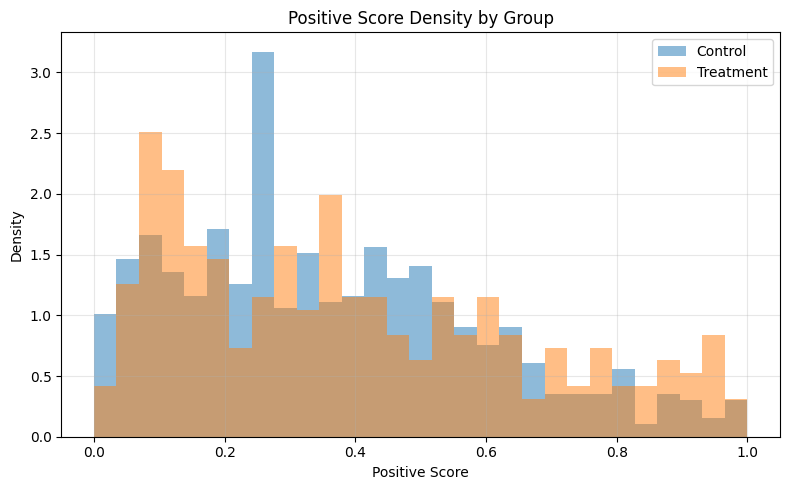

In [23]:
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 30)

plt.hist(
    df[df["group"] == 'control']["positive_score"].dropna(),
    bins=bins,
    alpha=0.5,
    label="Control",
    density=True
)

plt.hist(
    df[df["group"] == 'treatment']["positive_score"].dropna(),
    bins=bins,
    alpha=0.5,
    label="Treatment",
    density=True
)

plt.xlabel("Positive Score")
plt.ylabel("Density")
plt.title("Positive Score Density by Group")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
duckdb.query("""
    SELECT post_id, main_content, community, "group" AS grp, positive_score, stress_score
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY "group" ORDER BY RANDOM()) AS rn
        FROM df
        WHERE "group" IN ('treatment', 'control')
    )
    WHERE rn = 1;
""").df()

,post_id,main_content,community,grp,positive_score,stress_score
0,994123,"Does anybody eat clean? I have been wanting to do this for a while but I guess I'm a little intimidated. I work out like a fiend, but am not seeing much results because I eat a lot of junk. I was just curious if anyone has some tips or some go-to easy recipes. Thanks, Katrina",theknot,control,0.07997,0.034517
1,2qrkc5,"So since August of 2012 I've lost 85 lbs. I'm super excited about this and feel I've pretty much got to where I want to be weight wise, so I'm starting to tone. I started TRX this week and its been great. [Here are my pics!](http://imgur.com/a/dkH9N) The first is me 1 week post partum, the second is tonight. I went from 239 to 154, and I'm super happy about it.\n\nMy question is that right now I'm still holding weight around my waist. It's no where near as bad as it once was. but the last little bit of weight I lost came from my bust, and my waist remains virtually unchanged in the last 6 months. It's currently 35 inches whereas my bust is now 35.5 inches. I've had two giant babies who were 9lbs7.5oz and 11lbs2oz respectively so I don't expect a 6 pack or anything, but I'd like to lose a few more inches off my waist. I bought my wedding dress today and I had to size way up to accommodate this. Is this realistic, will it come with TRX/karate that I already do?",xxfitness,treatment,0.57583,0.019784


## Confounder 선정 및 인과 효과 추정 (IPW)

웨딩 관련 체형 관리 논의가 스트레스에 미치는 인과 효과를 추정하기 위해 역확률 가중치(Inverse Probability Weighting, IPW) 기법을 활용합니다.

다음 두 변수를 혼란변수(confounder)로 정의하고, 처치 확률(Propensity Score) 추정 모델에 포함합니다:

- **커뮤니티(`community`)**
  
  커뮤니티의 특성은
  - 웨딩 관련 논의에 참여할 확률과
  - 스트레스 표현 방식 및 강도 모두에 영향을 미칠 수 있는 요인입니다.

- **게시글 작성 시점(`year_month`)**  

  웨딩 시즌, 사회적 분위기, 계절적 요인 등 시간적 맥락은
  - 웨딩 관련 키워드 언급 여부와
  - 스트레스 수준 모두에 영향을 줄 수 있습니다.

### 단순 평균 비교와 혼란변수의 필요성

모든 커뮤니티에서 처치군(Treatment)은 대조군(Control)보다 평균 **스트레스 점수와 긍정 점수가 모두 높게** 나타납니다.  
또한 The Knot 커뮤니티는 xxfitness에 비해 전반적인 스트레스 수준이 높습니다.

하지만, The Knot 게시글은 웨딩 관련 주제로 분류될 가능성이 높기 때문에,  
커뮤니티 특성을 혼란변수로 통제하지 않을 경우, 웨딩 논의가 스트레스에 미치는 효과가 과대 추정될 위험이 있습니다.

In [27]:
duckdb.query("""
    SELECT
        community,
        "group" AS grp,
        COUNT(*) AS n,
        ROUND(AVG(stress_score), 4) AS avg_stress,
        ROUND(AVG(positive_score), 4) AS avg_positive,
    FROM df
    WHERE "group" IN ('treatment', 'control')
    GROUP BY community, "group"
    ORDER BY community, "group"
""").df()

,community,grp,n,avg_stress,avg_positive
0,theknot,control,173,0.1623,0.3725
1,theknot,treatment,236,0.2287,0.3899
2,xxfitness,control,403,0.1216,0.3599
3,xxfitness,treatment,41,0.1681,0.4278


### 성향 점수(Propensity Score) 추정

각 게시글이 **웨딩 관련 논의(처치군)**로 분류될 확률을 로지스틱 회귀를 통해 추정하고, 이를 성향 점수로 사용합니다.

사용된 모형은 다음과 같습니다:

$$
P(\text{treatment}=1)
= \beta_0
+ \beta_1 \,C(\text{community})
+ \beta_2 \,C(\text{year\_month})
$$

In [28]:
# 분석 대상: 처치군(treatment) 및 대조군(control)
df_analytic = df[df["group"].isin(["treatment", "control"])].copy()
df_analytic["treatment_indicator"] = (df_analytic["group"] == "treatment").astype(int)
df_analytic["year_month"] = df_analytic["year"].astype(str) + "-" + df_analytic["month"].astype(str)

# 유효한 year_month 필터링
ct_table = df_analytic.groupby(["year_month", "group"]).size().unstack(fill_value=0)
valid_ym = ct_table[(ct_table["control"] >= 1) & (ct_table["treatment"] >= 1)].index
df_analytic = df_analytic[df_analytic["year_month"].isin(valid_ym)]

In [29]:
# 로지스틱 회귀를 통한 성향 점수 추정
logit_model = smf.logit(
    formula="treatment_indicator ~ C(community) + C(year_month)",
    data=df_analytic
).fit(disp=0)

df_analytic["propensity_score"] = logit_model.predict(df_analytic)

df_analytic[["treatment_indicator", "stress_score", "propensity_score"]].head()

,treatment_indicator,stress_score,propensity_score
7,1,0.011812,0.683747
9,1,0.094599,0.505877
12,1,0.578927,0.593819
13,1,0.012260,0.658115
16,1,0.164461,0.800037


처치군은 주로 0.5 이상, 대조군은 0.6 이하 구간에 분포합니다.
두 그룹은 0.3~0.7 구간에서 겹쳐 있으며, 이는 공통 지원 조건(common support)을 충족하여 IPW 추정을 가능하게 합니다.

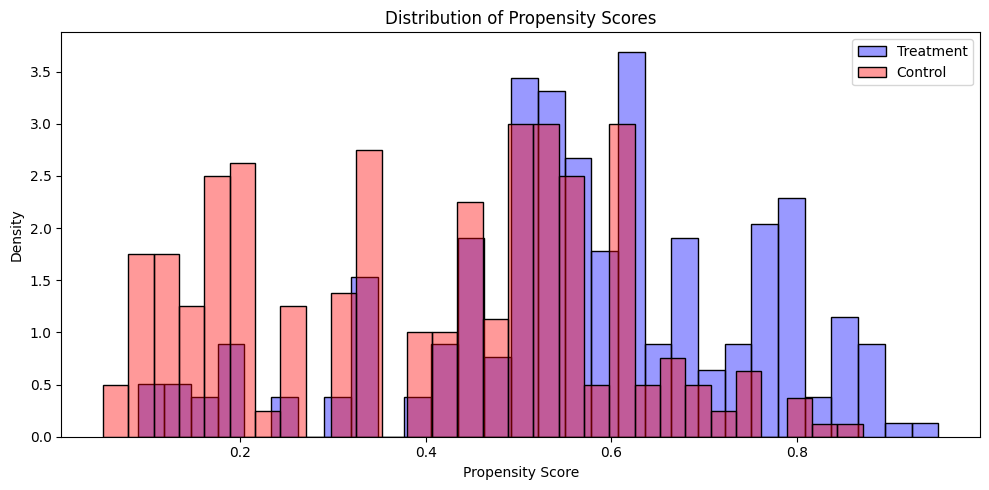

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_analytic[df_analytic["treatment_indicator"] == 1],
             x="propensity_score", bins=30, color="blue", alpha=0.4,
             label="Treatment", stat="density")
sns.histplot(data=df_analytic[df_analytic["treatment_indicator"] == 0],
             x="propensity_score", bins=30, color="red", alpha=0.4,
             label="Control", stat="density")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.title("Distribution of Propensity Scores")
plt.legend()
plt.tight_layout()
plt.show()

### IPW 적용 후 공변량 균형 확인 (SMD 분석)

In [31]:
# IPW 가중치 계산
p_t = df_analytic["treatment_indicator"].mean()
df_analytic["ipw"] = np.where(
    df_analytic["treatment_indicator"] == 1,
    p_t / df_analytic["propensity_score"],
    (1 - p_t) / (1 - df_analytic["propensity_score"])
)

# confounder 변수: community와 year_month (더미 변수화)
confounders = pd.get_dummies(df_analytic[["community", "year_month"]], drop_first=False)

IPW 적용 후 대부분의 공변량이 SMD 기준 0.1 이하로 감소하여, 처치군과 대조군의 공변량 분포가 유사해졌음을 확인할 수 있습니다.

In [32]:
# SMD(표준화 평균 차이) 계산 함수
def compute_smd(var, treat, weight=None):
    temp = pd.DataFrame({"var": var, "treat": treat})
    if weight is not None:
        temp["w"] = weight
        mean_t = np.average(temp[temp["treat"] == 1]["var"], weights=temp[temp["treat"] == 1]["w"])
        mean_c = np.average(temp[temp["treat"] == 0]["var"], weights=temp[temp["treat"] == 0]["w"])
    else:
        mean_t = temp[temp["treat"] == 1]["var"].mean()
        mean_c = temp[temp["treat"] == 0]["var"].mean()
    pooled_std = temp["var"].std()
    return abs(mean_t - mean_c) / pooled_std if pooled_std > 0 else 0

# SMD 분석 (각 변수별 가중치 전/후)
smd_results = {}
for col in confounders.columns:
    smd_before = compute_smd(confounders[col], df_analytic["treatment_indicator"])
    smd_after = compute_smd(confounders[col], df_analytic["treatment_indicator"], weight=df_analytic["ipw"])
    smd_results[col] = {"Before_IPW": smd_before, "After_IPW": smd_after}

smd_df = pd.DataFrame(smd_results).T.sort_values(by="Before_IPW", ascending=False)
smd_df.head()

,Before_IPW,After_IPW
community_theknot,0.628578,0.015612
community_xxfitness,0.628578,0.015612
year_month_2013-3,0.172637,0.026564
year_month_2015-8,0.152009,0.003839
year_month_2013-8,0.137984,0.053955


### ATE 추정


In [33]:
def compute_ipw_ate(data, score_col):
    treat = data[data["treatment_indicator"] == 1]
    control = data[data["treatment_indicator"] == 0]

    treat_mean = (treat[score_col] * treat["ipw"]).sum() / treat["ipw"].sum()
    control_mean = (control[score_col] * control["ipw"]).sum() / control["ipw"].sum()

    return treat_mean - control_mean

체중 관련 게시글 중 웨딩 관련 논의가 포함된 경우,  
그렇지 않은 게시글에 비해 평균적으로 **약 0.05 더 높은 스트레스 점수**를 보였습니다.

또한, 신뢰구간이 0을 포함하지 않아 해당 효과는 **통계적으로 유의**합니다.

In [34]:
# 스트레스 점수 ATE 추정
bootstrap_ates = Parallel(n_jobs=4)(
    delayed(compute_ipw_ate)(df_analytic.sample(frac=1, replace=True), "stress_score")
    for _ in range(1000)
)

ate_mean = np.mean(bootstrap_ates)
ci_lower, ci_upper = np.percentile(bootstrap_ates, [2.5, 97.5])

print(f"ATE: {ate_mean:.4f}")
print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

ATE: 0.0569
95% CI: (0.0113, 0.1064)


체중 관련 게시글 중 웨딩 관련 논의가 포함된 경우,  
평균적으로 **약 0.04 더 높은 긍정 점수**를 보였습니다.

다만, 신뢰구간이 0을 포함하므로 해당 효과는 **통계적으로 유의하지 않습니다**.

In [35]:
# 긍정 점수 ATE 추정
bootstrap_ates = Parallel(n_jobs=4)(
    delayed(compute_ipw_ate)(df_analytic.sample(frac=1, replace=True), "positive_score")
    for _ in range(1000)
)

ate_mean = np.mean(bootstrap_ates)
ci_lower, ci_upper = np.percentile(bootstrap_ates, [2.5, 97.5])

print(f"ATE: {ate_mean:.4f}")
print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

ATE: 0.0400
95% CI: (-0.0099, 0.0915)


## Robustness Check

인과 추정 결과의 **견고성(robustness)**을 평가하기 위해 다음 두 가지 분석을 진행합니다:

- 처치 배정 기준 민감도 분석
  - 토픽 확률 임계값(60%, 70%, 80%)을 조정했을 때 처치군/대조군 분류 및 결과가 일관되게 유지되는지 평가합니다.

- 커뮤니티별 효과 이질성 분석
  -  커뮤니티별 평균처치효과(ATE)의 차이를 통해 효과가 특정 커뮤니티에 국한되지 않고 일관되게 나타나는지 점검합니다.

### 처치 배정 기준 민감도 분석

토픽 확률 임계값을 **60%, 70%, 80%**로 조정하여 처치군과 대조군을 재분류하고,

각 기준에 대해 스트레스 점수 및 긍정 점수의 평균처치효과(ATE)와 95% 신뢰구간을 추정합니다.

In [36]:
# 분위수별 threshold 계산 및 처치 배정
quantile_thresholds = [0.6, 0.7, 0.8]
threshold_map = {
    int(q*100): {
        "body_thr": df["body_prob"].quantile(q),
        "wedding_thr": df["wedding_prob"].quantile(q)
    }
    for q in quantile_thresholds
}
for q in quantile_thresholds:
    key = int(q*100)
    df[f"group_q{key}"] = df.apply(
        lambda r: assign_group(r, threshold_map[key]["wedding_thr"], threshold_map[key]["body_thr"]),
        axis=1
    )

In [43]:
# 각 임계값별 샘플 분포 확인
result_frames = []

for q in quantile_thresholds:
    col = f"group_q{int(q*100)}"
    df_q = duckdb.query(f"""
        SELECT {int(q*100)} AS threshold,
               community,
               {col} AS grp,
               COUNT(*) AS N
        FROM df
        WHERE {col} IN ('treatment', 'control')
        GROUP BY community, {col}
        ORDER BY community, {col}
    """).df()
    result_frames.append(df_q)

full_result = pd.concat(result_frames, ignore_index=True)
display(full_result)

,threshold,community,grp,N
0,60,theknot,control,218
1,60,theknot,treatment,300
2,60,xxfitness,control,536
3,60,xxfitness,treatment,81
4,70,theknot,control,173
5,70,theknot,treatment,236
6,70,xxfitness,control,403
7,70,xxfitness,treatment,41
8,80,theknot,control,122
9,80,theknot,treatment,160


분석 결과, 모든 임계값에서 스트레스 점수와 긍정 점수 모두 양(+)의 평균처치효과(ATE)가 관찰되었습니다.  

다만, 임계값이 높아지고 표본 수가 줄어들수록 신뢰구간이 넓어지며 추정의 불확실성도 증가하는 경향이 나타났습니다.

특히, **스트레스 점수는 70% 임계값**, **긍정 점수는 60% 임계값**에서만 통계적으로 유의한 효과가 확인되었습니다.  
이는 웨딩 관련 체형 관리 논의의 정서적 효과가 단순한 언급 여부를 넘어서, 논의의 구체성과 강도에 따라 달라질 수 있음을 시사합니다.

즉, **논의가 포괄적이고 가벼울수록 긍정 정서가**, **보다 구체적이고 강도 높게 전개될수록 스트레스 반응이** 두드러지는 양상이 관찰되었습니다.

In [39]:
sensitivity_results = []

for q in [60, 70, 80]:
    grp = f"group_q{q}"
    temp = df[df[grp].isin(['treatment', 'control'])].copy()
    temp['treatment_indicator'] = (temp[grp] == 'treatment').astype(int)
    temp['year_month'] = temp['year'].astype(str) + '-' + temp['month'].astype(str)

    # 유효 연월 필터링
    ct = temp.groupby(['year_month', grp]).size().unstack(fill_value=0)
    valid = ct[(ct['control'] >= 1) & (ct['treatment'] >= 1)].index
    temp = temp[temp['year_month'].isin(valid)]

    # 성향점수·IPW 계산
    logit = smf.logit('treatment_indicator ~ C(community) + C(year_month)', data=temp).fit(disp=False)
    temp['ps'] = logit.predict(temp)
    p_t = temp['treatment_indicator'].mean()
    temp['ipw'] = np.where(
        temp['treatment_indicator'] == 1,
        p_t / temp['ps'],
        (1 - p_t) / (1 - temp['ps'])
    )

    # ATE 부트스트랩
    stress_bs = Parallel(n_jobs=4)(
        delayed(compute_ipw_ate)(temp.sample(frac=1, replace=True), 'stress_score') for _ in range(500)
    )
    pos_bs = Parallel(n_jobs=4)(
        delayed(compute_ipw_ate)(temp.sample(frac=1, replace=True), 'positive_score') for _ in range(500)
    )

    sensitivity_results.append({
        'threshold': f"{q}%",
        'N': len(temp),
        'stress_ate': round(np.mean(stress_bs), 3),
        'stress_ci_lower': round(np.percentile(stress_bs, 2.5), 3),
        'stress_ci_upper': round(np.percentile(stress_bs, 97.5), 3),
        'stress_sd': round((np.percentile(stress_bs, 97.5) - np.percentile(stress_bs, 2.5)) / 3.92, 3),
        'positive_ate': round(np.mean(pos_bs), 3),
        'positive_ci_lower': round(np.percentile(pos_bs, 2.5), 3),
        'positive_ci_upper': round(np.percentile(pos_bs, 97.5), 3),
        'positive_sd': round((np.percentile(pos_bs, 97.5) - np.percentile(pos_bs, 2.5)) / 3.92, 3)
    })

sensitivity_df = pd.DataFrame(sensitivity_results)
display(sensitivity_df)

,threshold,N,stress_ate,stress_ci_lower,stress_ci_upper,stress_sd,positive_ate,positive_ci_lower,positive_ci_upper,positive_sd
0,60%,830,0.032,-0.012,0.072,0.021,0.050,0.009,0.090,0.021
1,70%,566,0.055,0.008,0.101,0.024,0.041,-0.015,0.093,0.028
2,80%,346,0.041,-0.015,0.098,0.029,0.027,-0.039,0.097,0.035


### 커뮤니티별 효과 이질성 분석

분석 결과, 두 커뮤니티 모두 스트레스와 긍정 점수의 **효과 방향은 일관되게 양(+)**으로 나타났지만,  
통계적으로 유의한 효과는 The Knot의 스트레스 점수에서만 확인되었습니다.

이러한 차이는 각 커뮤니티에서 이루어지는 논의의 맥락과 표현 강도의 차이에서 비롯된 것으로 보입니다.  
The Knot에서는 웨딩 관련 논의가 더 구체적이고 강하게 이루어지며,  
그에 따라 **스트레스 반응이 보다 뚜렷하게 나타나는 경향**이 보였습니다.

반면, xxfitness에서는 **긍정과 스트레스가 함께 나타나는 정서적 복합성**이  
상대적으로 더 자주 포착되는 양상을 보였습니다.

또한, xxfitness는 웨딩 관련 게시글 수가 적어  
**긍정 효과가 실제보다 과소추정되었을 가능성**도 존재합니다.


In [42]:
communities = df_analytic["community"].unique()
subgroup_results = []

for comm in communities:
    df_sub = df_analytic[df_analytic["community"] == comm].copy()

    # 스트레스 점수 ATE
    stress_boot = Parallel(n_jobs=4)(
        delayed(compute_ipw_ate)(df_sub.sample(frac=1, replace=True), "stress_score")
        for _ in range(1000)
    )
    stress_mean = np.mean(stress_boot)
    stress_ci_l, stress_ci_u = np.percentile(stress_boot, [2.5, 97.5])
    stress_sd = (stress_ci_u - stress_ci_l) / 3.92

    # 긍정 점수 ATE
    pos_boot = Parallel(n_jobs=4)(
        delayed(compute_ipw_ate)(df_sub.sample(frac=1, replace=True), "positive_score")
        for _ in range(1000)
    )
    pos_mean = np.mean(pos_boot)
    pos_ci_l, pos_ci_u = np.percentile(pos_boot, [2.5, 97.5])
    pos_sd = (pos_ci_u - pos_ci_l) / 3.92

    subgroup_results.append({
        "community": comm,
        "stress_ate": round(stress_mean, 3),
        "stress_ci_lower": round(stress_ci_l, 3),
        "stress_ci_upper": round(stress_ci_u, 3),
        "stress_sd": round(stress_sd, 3),
        "positive_ate": round(pos_mean, 3),
        "positive_ci_lower": round(pos_ci_l, 3),
        "positive_ci_upper": round(pos_ci_u, 3),
        "positive_sd": round(pos_sd, 3),
    })

results_df = pd.DataFrame(subgroup_results)
display(results_df)


,community,stress_ate,stress_ci_lower,stress_ci_upper,stress_sd,positive_ate,positive_ci_lower,positive_ci_upper,positive_sd
0,theknot,0.069,0.017,0.123,0.027,0.016,-0.042,0.073,0.029
1,xxfitness,0.022,-0.078,0.129,0.053,0.091,-0.009,0.193,0.051


## 결론 및 시사점

종합적으로, 웨딩 관련 체형 관리 논의는 정서적 지표에서 일관되게 **양(+)의 효과**를 보였습니다. 그러나 분석에서 사용한 임계값 및 커뮤니티 특성에 따라 효과의 강도와 통계적 유의성이 달라지는 것을 확인했습니다.

이는 웨딩 관련 논의가 정서적 반응을 촉발하는 데 있어 단순히 언급 여부가 아니라 **논의의 구체성, 표현 강도, 그리고 커뮤니티의 맥락**과 밀접히 연결되어 있음을 의미합니다.

임계값을 높일수록 표본 수가 감소하여 효과 추정의 통계적 유의성이 감소했으나, 효과의 방향성과 크기를 고려할 때 실제 긍정적 효과가 보수적으로 추정되었을 가능성을 배제할 수 없습니다.

이에 따라 향후 연구에서는 다음과 같은 사항을 고려할 필요가 있습니다:

- 웨딩 관련 논의의 구체성 및 표현 강도를 정밀하게 포착하기 위한 질적 연구 접근의 병행
- 다양한 커뮤니티를 추가적으로 포함하여 효과의 일반화 가능성 탐색
- 충분한 표본 확보를 통한 통계적 검정력의 강화 및 보다 정교한 효과 추정